In [69]:
# Notebook configuration

## Additional logging to show much more information about the data
add_logging = False

## Model tuning - switch only once or if required, may take around hour
run_tuning = False 

# HR Analytics

## Introduction

### Phases of the Data Science experiment
1. Define your problem by Business Question
2. Gather data
3. Exploratory Data Analysis
4. Data preparation
5. Models creation
6. Models evaluation and finding the most suitable for the problem
7. Deployment and results presentation


#### Phase 1: Business Question

### Situation description
Current Employer that leads BigData&Analytics department provides free training for its employees that want to upskill in the Data domain. The Company as well as its HR Department want to know which employees should bne allowed to do the course to actually upskill them, but not to lose them afterwards.

### Business Questions
1. Will given employee change the job after we give him a DataScience training?
2. Based on which factors we should set a prioritization to provide the Data Science training?

#### Phase 2: Gather data

In [70]:
# Import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

import time

In [71]:
df_hr = pd.read_csv("data/hr_data.csv", index_col="enrollee_id")

#### Phase 3: EDA

In [72]:
print(df_hr.columns)
print("")
print(df_hr.describe())

# Observation - 19158 records, 12 attributes and binary target, 
#   target = 0 means that employee after taking the training does not look for a job, 
#   target = 1 means they are actively searching for opportunities outside of the Company that provided him traning
# Conclusion - there is enough data to provide advanced analytics for binary classification

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

       city_development_index  training_hours        target
count            19158.000000    19158.000000  19158.000000
mean                 0.828848       65.366896      0.249348
std                  0.123362       60.058462      0.432647
min                  0.448000        1.000000      0.000000
25%                  0.740000       23.000000      0.000000
50%                  0.903000       47.000000      0.000000
75%                  0.920000       88.000000      0.000000
max                  0.949000      336.000000      1.000000


In [73]:
print("Null Check for Training Set:\n", df_hr.isna().any())

# Observation - data has missing values that have to be analyzed and potentially preprocessed

Null Check for Training Set:
 city                      False
city_development_index    False
gender                     True
relevent_experience       False
enrolled_university        True
education_level            True
major_discipline           True
experience                 True
company_size               True
company_type               True
last_new_job               True
training_hours            False
target                    False
dtype: bool


In [74]:
print(df_hr["target"].value_counts())

# Observation - imbalanced set (0.25 vs 0.75)
# Conclusion - model average accuracy should be above 80% to provide any value

0.0    14381
1.0     4777
Name: target, dtype: int64


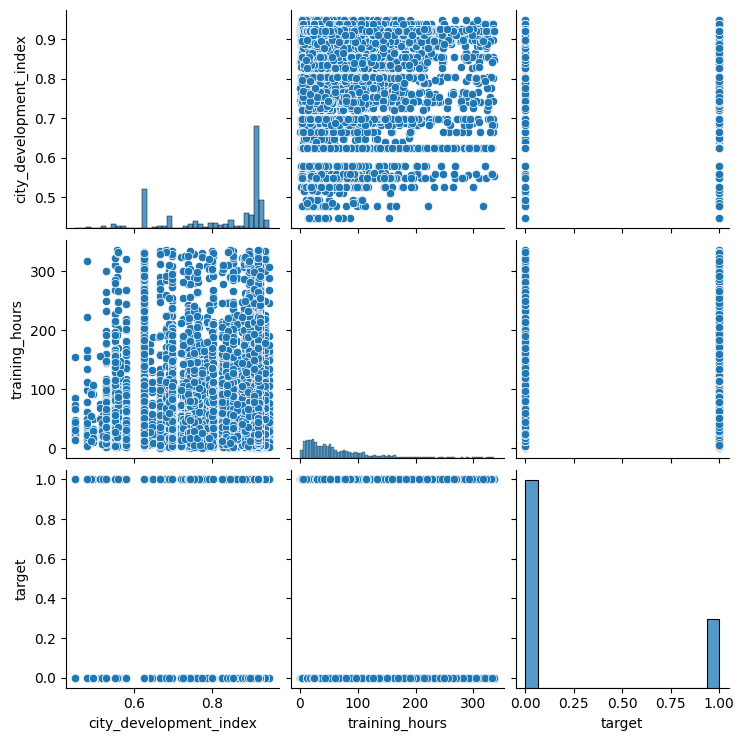

In [75]:
sns.pairplot(df_hr)

<AxesSubplot: xlabel='target', ylabel='training_hours'>

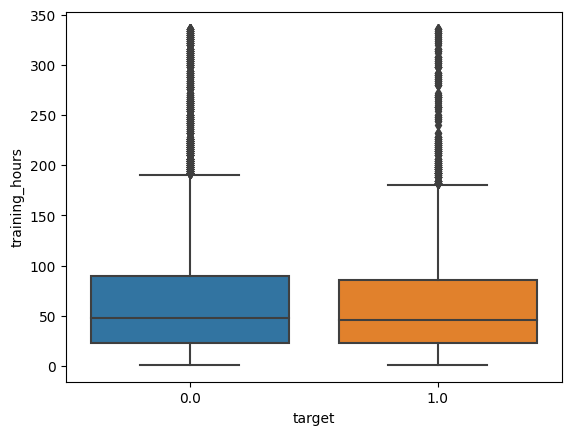

In [76]:
sns.boxplot(data=df_hr, x="target", y="training_hours")

<AxesSubplot: xlabel='target', ylabel='education_level'>

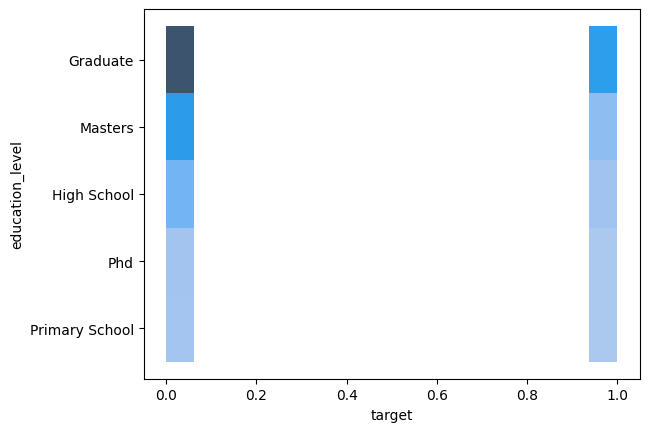

In [77]:
sns.histplot(df_hr, y="education_level", x="target")

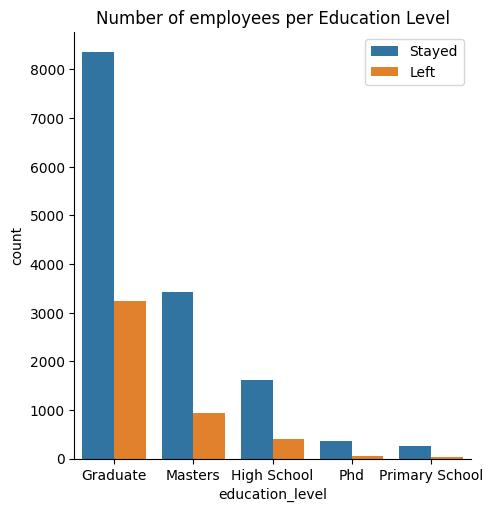

In [78]:
plot = sns.catplot(data=df_hr, x='education_level', hue='target', kind="count", legend=False).set(title="Number of employees per Education Level")
plt.legend(labels=["Stayed", "Left"])
plt.show(plot)

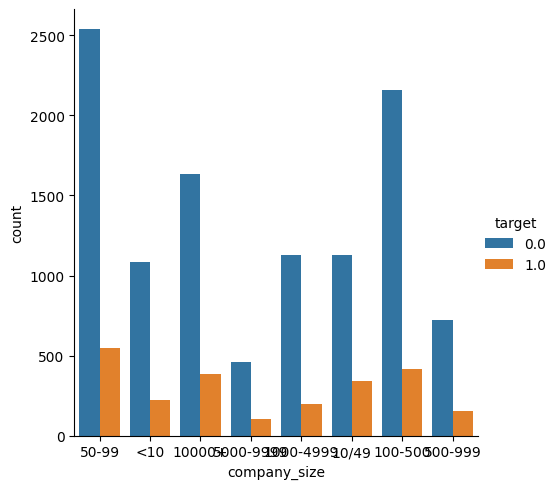

In [79]:
sns.catplot(data=df_hr, x='company_size',hue='target', kind="count")

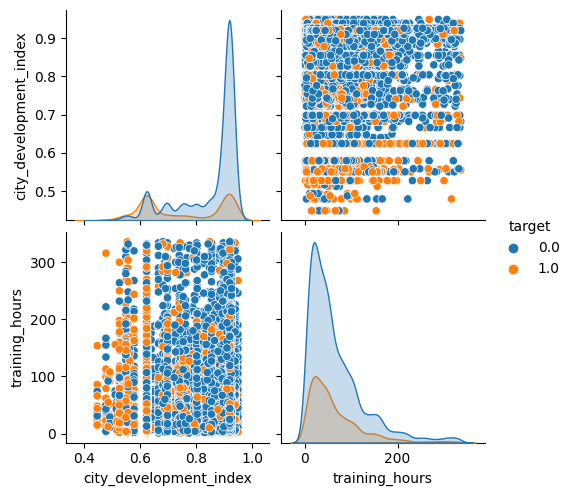

In [80]:
sns.pairplot(df_hr, hue="target")

# Observations:
#   Lower city development index means much more chance for Employee to actively look for a job change
#   In general number of training hours taken do not provide much information

C:\Users\Filip\AppData\Local\Temp\ipykernel_10980\2504848497.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_hr.corr(), annot = True)


<AxesSubplot: >

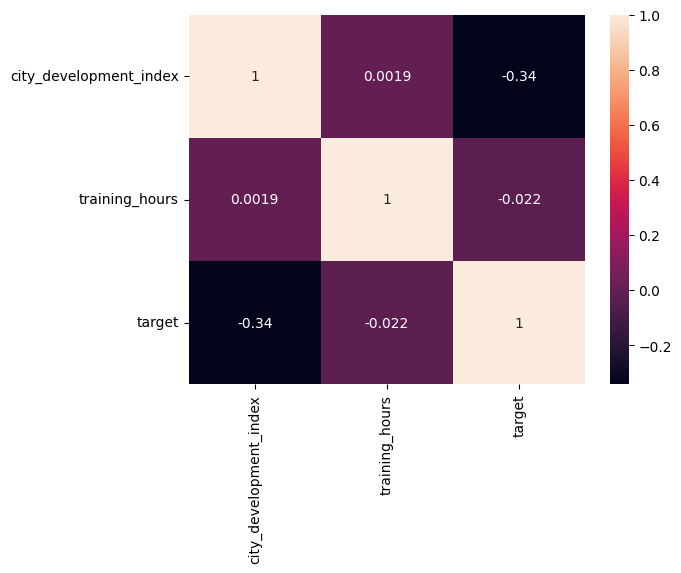

In [81]:
sns.heatmap(df_hr.corr(), annot = True)

#### Phase 4: Data Preparation

In [82]:
# As we are going to use classification algorithms we should test different data processing techniques
df_hr_processed = df_hr.copy()
df_hr_processed_and_scaled = df_hr.copy()

# Standard processin

if add_logging:
    for col in df_hr_processed.columns:
        print("------\n", df_hr_processed[col].value_counts(), "\nNumber of distinct values:", len(set(df_hr_processed[col])))
        print("Number of missing values:", df_hr_processed[col].isnull().sum())
        if col in ["city_development_index", "training_hours"]:
            print("Values range:", df_hr_processed[col].min(), " - ", df_hr_processed[col].max())

""" 
Columns to be processed
    city - dummy
    city_development_index - nothing (no standarization needed)
    gender - dummy, other into gender_other, NaN into gender_unknown
    relevent_experience - switch to binary
    enrolled_university - dummy, missing values to be removed
    education_level - dummy, missing values to be removed
    major_discipline - dummy, other into major_discipline_other, missing values to be removed
    experience - bucketing, missing values to be removed
    company_size - bucketing, 10/49 -> 10-49, NaN -> -1
    company_type - dummy, Other -> company_type_Other
    last_new_job - bucketing, NaN -> last_new_job_unknown
    training_hours - nothing, optional standarization
"""
# No outliers detection required

# Switch 0 and 1 in target - 1 should be employees who are going to stay
df_hr_processed["target"] = df_hr_processed['target'].apply(lambda x: abs(x - 1))

# Change needed values
columns_with_missing_values = ["gender", "enrolled_university", "education_level", "major_discipline", "experience", "company_size", "last_new_job"]
columns_to_update = ["gender", "relevent_experience", "major_discipline", "company_size", "company_type"]
columns_to_bucketize = ["experience", "company_size", "last_new_job"]
columns_to_dummify = ["city", "gender", "enrolled_university", "education_level", "major_discipline", "company_type", "last_new_job", "experience", "company_size", "last_new_job"]
columns_to_standardize = ["training_hours"]

# Update missing values
df_hr_processed.loc[df_hr_processed["gender"].isnull(), "gender"] = "gender_unknown"
df_hr_processed.loc[df_hr_processed["company_size"].isnull(), "company_size"] = "-1"
df_hr_processed.loc[df_hr_processed["last_new_job"].isnull(), "last_new_job"] = "last_new_job_unknown"
df_hr_processed = df_hr_processed[df_hr_processed["enrolled_university"].notna()]
df_hr_processed = df_hr_processed[df_hr_processed["education_level"].notna()]
df_hr_processed = df_hr_processed[df_hr_processed["major_discipline"].notna()]
df_hr_processed = df_hr_processed[df_hr_processed["experience"].notna()]

if add_logging:
    for col in columns_with_missing_values:
        print(df_hr_processed[col].isna().sum())
        print(df_hr_processed[col].value_counts())


# Update invalid or improper values
df_hr_processed["gender"] = df_hr_processed["gender"].replace({
    "Other" : "gender_Other"
})

df_hr_processed["relevent_experience"] = df_hr_processed["relevent_experience"].replace({
    "No relevent experience" : 0,
    "Has relevent experience" : 1
})

df_hr_processed["major_discipline"] = df_hr_processed["major_discipline"].replace({
    "Other" : "gender_Other"
})

df_hr_processed["company_size"] = df_hr_processed["company_size"].replace({
    "10/49" : "10-49"
})

df_hr_processed["company_type"] = df_hr_processed["company_type"].replace({
    "Other" : "company_type_Other"
})



# Bucketing range values
df_hr_processed["experience"] = df_hr_processed["experience"].replace({
    "<1" : 0,
    ">20" : 21
})
df_hr_processed["experience"] = df_hr_processed["experience"].astype(int)
experience_bins = np.array([-1, 0, 1, 3, 5, 10, 20, 99])
df_hr_processed["experience"] = pd.cut(df_hr_processed["experience"], bins=experience_bins)
print(df_hr_processed["experience"].value_counts())


df_hr_processed["company_size"] = df_hr_processed["company_size"].replace({
           "-1" : -1,
          "<10" : 5,
        "10-49" : 30,
        "50-99" : 75,
      "100-500" : 300,
      "500-999" : 750,
    "1000-4999" : 3000,
    "5000-9999" : 7500,
       "10000+" : 50000
})
company_size_bins = np.array([-2, 0, 9, 49, 99, 999, 4999, 9999, 1000000000])
df_hr_processed["company_size"] = pd.cut(df_hr_processed["company_size"], bins=company_size_bins)
print(df_hr_processed["company_size"].value_counts())

# Dummify
## Last New Job - Amount of time can be the strongest discriminator so the decision is to use dummy values to create a vector out of it, experience may have a huge impact on mindset
df_hr_processed["last_new_job"] = df_hr_processed["last_new_job"].replace({
    "never" : "last_new_job_never",
        "1" : "last_new_job_1",
        "2" : "last_new_job_2",
        "3" : "last_new_job_3",
        "4" : "last_new_job_4",
       ">4" : "last_new_job_over_4",
})

df_hr_processed = pd.get_dummies(df_hr_processed, columns=columns_to_dummify)

if add_logging:
    print(df_hr_processed.columns)

print(df_hr_processed.shape)

# Observation: final shape = 16070 x 177

(5, 10]     4296
(10, 20]    4045
(20, 99]    3076
(3, 5]      2206
(1, 3]      1725
(0, 1]       372
(-1, 0]      350
Name: experience, dtype: int64
(-2, 0]               4104
(99, 999]             3167
(49, 99]              2761
(9999, 1000000000]    1888
(9, 49]               1299
(999, 4999]           1213
(0, 9]                1122
(4999, 9999]           516
Name: company_size, dtype: int64
(16070, 177)


In [83]:
# Optional training_hours standarization
df_hr_processed_and_scaled = df_hr_processed.copy()

# sns.boxplot(x=df_hr_processed_and_scaled["training_hours"])
# sns.histplot(df_hr_processed_and_scaled["training_hours"])

scaler = StandardScaler()
df_hr_processed_and_scaled["training_hours_new"] = scaler.fit_transform(df_hr_processed_and_scaled["training_hours"].to_numpy().reshape(-1, 1))

df_hr_processed_and_scaled.drop(columns=["training_hours"], inplace=True)
df_hr_processed_and_scaled.rename(columns={ "training_hours_new" : "training_hours" }, inplace=True)

# sns.boxplot(x=df_hr_processed_and_scaled["training_hours"])
# sns.histplot(df_hr_processed_and_scaled["training_hours"])


#### Phase 5: Model creation

##### Split data

In [84]:
# We have prepared the data in 3 ways=no processing, processing and processing with scaling

# Split data

X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(
    df_hr_processed.loc[:, df_hr_processed.columns != "target"], 
    df_hr_processed.loc[:, df_hr_processed.columns == "target"], 
    test_size=0.30, 
    random_state=42
)

X_train_processed_and_scaled, X_test_processed_and_scaled, y_train_processed_and_scaled, y_test_processed_and_scaled = train_test_split(
    df_hr_processed_and_scaled.loc[:, df_hr_processed_and_scaled.columns != "target"], 
    df_hr_processed_and_scaled.loc[:, df_hr_processed_and_scaled.columns == "target"], 
    test_size=0.30, 
    random_state=42
)

print(X_train_processed.shape, X_test_processed.shape, y_train_processed.shape, y_test_processed.shape)
print(X_train_processed_and_scaled.shape, X_test_processed_and_scaled.shape, y_train_processed_and_scaled.shape, y_test_processed_and_scaled.shape)

(11249, 176) (4821, 176) (11249, 1) (4821, 1)
(11249, 176) (4821, 176) (11249, 1) (4821, 1)


##### Define and Train models

In [85]:
models = {}

models["Random Forest - Processed"]      = RandomForestClassifier()
models["Naive Bayes - Processed"]        = GaussianNB()
models["K-Nearest Neighbor - Processed"] = KNeighborsClassifier()
models["Random Forest - Processed and Scaled"]      = RandomForestClassifier()
models["Naive Bayes - Processed and Scaled"]        = GaussianNB()
models["K-Nearest Neighbor - Processed and Scaled"] = KNeighborsClassifier()

accuracy, precision, recall, f1, train_time = {}, {}, {}, {}, {}

## Train models on preprocessed data without training_hours standarization
for key in ["Random Forest - Processed", "Naive Bayes - Processed", "K-Nearest Neighbor - Processed"]:   
    # Fit the classifier
    start_time = time.time()

    models[key].fit(X_train_processed, y_train_processed)

    end_time = time.time()
    
    # Make predictions
    predictions = models[key].predict(X_test_processed)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test_processed)
    precision[key] = precision_score(predictions, y_test_processed)
    recall[key] = recall_score(predictions, y_test_processed)
    f1[key] = f1_score(predictions, y_test_processed)

    train_time[key] = (round(end_time - start_time, 3), "s")


## Train models on preprocessed data with training_hours standarization
for key in ["Random Forest - Processed and Scaled", "Naive Bayes - Processed and Scaled", "K-Nearest Neighbor - Processed and Scaled"]:   
    # Fit the classifier
    start_time = time.time()

    models[key].fit(X_train_processed_and_scaled, y_train_processed_and_scaled)

    end_time = time.time()
    
    # Make predictions
    predictions = models[key].predict(X_test_processed_and_scaled)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test_processed_and_scaled)
    precision[key] = precision_score(predictions, y_test_processed_and_scaled)
    recall[key] = recall_score(predictions, y_test_processed_and_scaled)
    f1[key] = f1_score(predictions, y_test_processed_and_scaled)

    train_time[key] = (round(end_time - start_time, 3), "s")



df_model = pd.DataFrame(index=models.keys(), columns=["Accuracy", "Precision", "Recall", "F1 Score", "Processing Time"])
df_model["Accuracy"] = accuracy.values()
df_model["Precision"] = precision.values()
df_model["Recall"] = recall.values()
df_model["F1 Score"] = f1.values()
df_model["Processing Time"] = train_time.values()

df_model

C:\Users\Filip\AppData\Local\Temp\ipykernel_10980\975973549.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  models[key].fit(X_train_processed, y_train_processed)
C:\Users\Filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\

,Accuracy,Precision,Recall,F1 Score,Processing Time
Random Forest - Processed,0.769342,0.860995,0.834996,0.847796,"(2.097, s)"
Naive Bayes - Processed,0.492844,0.378093,0.867347,0.526621,"(0.048, s)"
K-Nearest Neighbor - Processed,0.734702,0.869892,0.794162,0.830304,"(0.022, s)"
Random Forest - Processed and Scaled,0.769757,0.862107,0.834724,0.848195,"(2.023, s)"
Naive Bayes - Processed and Scaled,0.376063,0.192383,0.870440,0.315118,"(0.049, s)"
K-Nearest Neighbor - Processed and Scaled,0.740095,0.840145,0.816757,0.828286,"(0.022, s)"


##### Tuning

In [86]:
if run_tuning:
    rfc_model = RandomForestClassifier()

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ["auto", "sqrt"]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {
        "n_estimators" : n_estimators,
        "max_features" : max_features,
        "max_depth" : max_depth,
        "min_samples_split" : min_samples_split,
        "min_samples_leaf" : min_samples_leaf,
        "bootstrap" : bootstrap
    }
    print(random_grid)

    rf_random = RandomizedSearchCV(estimator = rfc_model, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    # Fit the random search model
    rf_random.fit(X_train_processed, y_train_processed)
    rf_random.best_params_


In [87]:
if run_tuning:
    nb_model = GaussianNB()

    # Portion of the largest variance of all features that is added to variances for calculation stability.
    var_smoothing = [float(x) for x in np.linspace(start = 0.000000001, stop = 0.000000100, num = 10)]
    # Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.
    priors = [[0.75, 0.25], [0.5, 0.5], None]

    # Create the random grid
    random_grid = {
        "var_smoothing" : var_smoothing,
        "priors" : priors
    }
    print(random_grid)

    nb_random = RandomizedSearchCV(estimator = nb_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    # Fit the random search model
    nb_random.fit(X_train_processed, y_train_processed)
    nb_random.best_params_

In [88]:
if run_tuning:
    knn_model = KNeighborsClassifier()

    # Number of neighbors to use by default for kneighbors queries.
    n_neighbors = [int(x) for x in np.linspace(start = 3, stop = 30, num = 1)]
    # Weight function used in prediction
    weights = ["uniform", "distance"]
    # Algorithm used to compute the nearest neighbors:
    algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
    # Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.
    p = [1, 2]

    # Create the random grid
    random_grid = {
        "n_neighbors" : n_neighbors,
        "weights" : weights,
        "algorithm" : algorithm,
        "p" : p
    }
    print(random_grid)

    knn_random = RandomizedSearchCV(estimator = knn_model, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # Fit the random search model
    knn_random.fit(X_train_processed, y_train_processed)
    knn_random.best_params_

##### Train models on tuned values

In [89]:
models = {}

models["Random Forest - Processed"]      = RandomForestClassifier(n_estimators=200, min_samples_split= 5, min_samples_leaf=4, max_features="auto", max_depth=100, bootstrap=False)
models["Naive Bayes - Processed"]        = GaussianNB(var_smoothing=8.899999999999999e-08, priors=None)
models["K-Nearest Neighbor - Processed"] = KNeighborsClassifier(weights="uniform", p=1, n_neighbors=3, algorithm="auto")
models["Random Forest - Processed and Scaled"]      = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features="auto", max_depth=100, bootstrap=False)
models["Naive Bayes - Processed and Scaled"]        = GaussianNB(var_smoothing=8.899999999999999e-08, priors=None)
models["K-Nearest Neighbor - Processed and Scaled"] = KNeighborsClassifier(weights="uniform", p=1, n_neighbors=3, algorithm="auto")

accuracy, precision, recall, f1, train_time = {}, {}, {}, {}, {}

## Train models on preprocessed data without training_hours standarization
for key in ["Random Forest - Processed", "Naive Bayes - Processed", "K-Nearest Neighbor - Processed"]:
    # Fit the classifier
    start_time = time.time()

    models[key].fit(X_train_processed, y_train_processed)

    end_time = time.time()
    
    # Make predictions
    predictions = models[key].predict(X_test_processed)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test_processed)
    precision[key] = precision_score(predictions, y_test_processed)
    recall[key] = recall_score(predictions, y_test_processed)
    f1[key] = f1_score(predictions, y_test_processed)

    train_time[key] = (round(end_time - start_time, 3), "s")


## Train models on preprocessed data with training_hours standarization
for key in ["Random Forest - Processed and Scaled", "Naive Bayes - Processed and Scaled", "K-Nearest Neighbor - Processed and Scaled"]:    
    # Fit the classifier
    start_time = time.time()

    models[key].fit(X_train_processed_and_scaled, y_train_processed_and_scaled)

    end_time = time.time()
    
    # Make predictions
    predictions = models[key].predict(X_test_processed_and_scaled)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test_processed_and_scaled)
    precision[key] = precision_score(predictions, y_test_processed_and_scaled)
    recall[key] = recall_score(predictions, y_test_processed_and_scaled)
    f1[key] = f1_score(predictions, y_test_processed_and_scaled)

    train_time[key] = (round(end_time - start_time, 3), "s")



df_model = pd.DataFrame(index=models.keys(), columns=["Accuracy", "Precision", "Recall", "F1 Score", "Processing Time"])
df_model["Accuracy"] = accuracy.values()
df_model["Precision"] = precision.values()
df_model["Recall"] = recall.values()
df_model["F1 Score"] = f1.values()
df_model["Processing Time"] = train_time.values()

df_model

C:\Users\Filip\AppData\Local\Temp\ipykernel_10980\1920102507.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  models[key].fit(X_train_processed, y_train_processed)
C:\Users\Filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

,Accuracy,Precision,Recall,F1 Score,Processing Time
Random Forest - Processed,0.773491,0.864609,0.837147,0.850656,"(3.462, s)"
Naive Bayes - Processed,0.680149,0.671393,0.870270,0.758004,"(0.052, s)"
K-Nearest Neighbor - Processed,0.711886,0.826800,0.795187,0.810686,"(0.025, s)"
Random Forest - Processed and Scaled,0.775773,0.864609,0.839633,0.851938,"(3.174, s)"
Naive Bayes - Processed and Scaled,0.416304,0.257715,0.865546,0.397172,"(0.049, s)"
K-Nearest Neighbor - Processed and Scaled,0.727028,0.819016,0.815840,0.817425,"(0.023, s)"


#### Phase 6: Models evaluation and finding the most suitable for the problem

[2.27474173e-01 3.08495553e-02 6.43886785e-06 6.04062973e-05
 1.05059072e-03 1.18987306e-03 1.05100259e-03 1.61216659e-02
 1.28302421e-03 1.15341655e-04 9.62997802e-06 0.00000000e+00
 0.00000000e+00 1.04444279e-02 0.00000000e+00 6.99638950e-03
 5.20800184e-04 2.29091921e-04 0.00000000e+00 2.83448148e-04
 2.09362293e-06 0.00000000e+00 0.00000000e+00 2.95377639e-04
 8.68054052e-05 2.33621212e-06 1.55767691e-03 0.00000000e+00
 2.45736541e-05 0.00000000e+00 0.00000000e+00 4.16919622e-05
 4.41091514e-03 1.74838077e-04 0.00000000e+00 5.51318763e-05
 3.58949541e-06 3.35791379e-04 3.81560112e-05 3.52528099e-04
 5.51913019e-04 0.00000000e+00 1.87627851e-04 5.06117420e-05
 4.00752937e-05 3.68769472e-04 4.34479367e-06 2.20762187e-04
 5.18551260e-04 1.19809106e-02 5.66483348e-03 6.65802468e-04
 4.09016290e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.39662891e-04 0.00000000e+00 3.70963643e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.44306872e-04 0.00000000e+00
 7.79803033e-06 1.585596

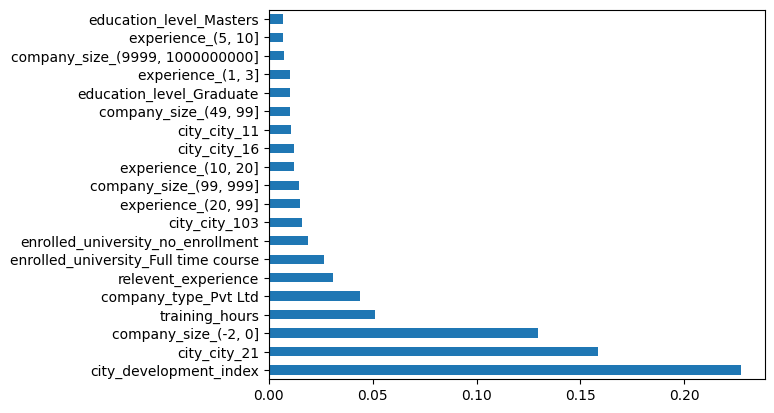

In [90]:
print(models["Random Forest - Processed and Scaled"].feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(models["Random Forest - Processed and Scaled"].feature_importances_, index=X_test_processed_and_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

To be able to prioritize training people that will not search the job we need to maximize successfull 1 recognition - these employees are going to be first on the training list.
Goal - minimize False Positive - maximize Precision 

In that case the best model is definitely Random Forest trained on processed and scaled data, around 0.86 Precision.

The most important factors:
1. City Development Index from whence the Employee comes
2. The Employee comes from City 21
3. This is the first Employer of the Employee
4. Number of training hours
5. Current Employee's Company is a Private Company